In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
data = pd.read_csv('Data/data_table.csv')
print("Number of columns:", len(data.columns))
print("Number of observations:", len(data))
print("\nColumn names:")
for col in data.columns:
    print(f"{col}: {data[col].dtype}, first 3 entries: {data[col].head(3).tolist()}")

Number of columns: 1571
Number of observations: 26638

Column names:
person_id: int64, first 3 entries: [1, 1, 1]
viscount: int64, first 3 entries: [1, 2, 3]
age: float64, first 3 entries: [37.0, 38.0, 38.0]
gender: object, first 3 entries: ['Female', 'Female', 'Female']
ACAMPROSATE  CALCIUM: int64, first 3 entries: [0, 0, 0]
ACARBOSE: int64, first 3 entries: [0, 0, 0]
ACETAMINOPHEN: int64, first 3 entries: [0, 0, 0]
ACETAMINOPHEN W/CODEINE 15 MG: int64, first 3 entries: [0, 0, 0]
ACETAMINOPHEN, ASA, CAFFEINE: int64, first 3 entries: [0, 0, 0]
ACETAMINOPHEN; COMB.; CHLORPHENIRAMINE MALEATE; DEXTROMETHORPHAN HBR; PSEUDOEPHEDRINE HCL: int64, first 3 entries: [0, 0, 0]
ACETAMINOPHEN; COMB.; DEXTROMETHORPHAN HBR; DOXYLAMINE SUCCINATE; PSEUDOEPHEDRINE HCL: int64, first 3 entries: [0, 0, 0]
ACETAMINOPHEN; COMB.; DIPHENHYDRAMINE HCL: int64, first 3 entries: [0, 0, 0]
ACETAZOLAMIDE: int64, first 3 entries: [0, 0, 0]
ACETIC ACID (EENT): int64, first 3 entries: [0, 0, 0]
ACETYLCYSTEINE: int64, f

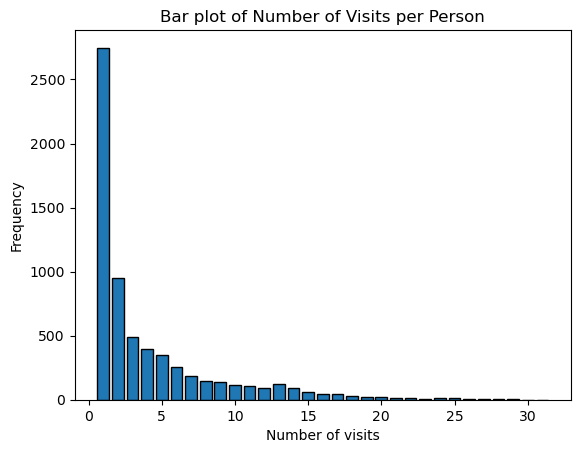

   Number of Visits  Frequency  Percentage
0                 1       2748   42.329020
1                 2        952   14.664202
2                 3        490    7.547751
3                 4        398    6.130622
4                 5        349    5.375847
5                 6        255    3.927911
6                 7        182    2.803450
7                 8        145    2.233518
8                 9        141    2.171904
9                10        114    1.756007


In [11]:
#Count the number of visits for each person
visits = data.groupby('person_id').size()

# Plot the bar plot
visit_counts = visits.value_counts().sort_index()
plt.bar(visit_counts.index, visit_counts.values, edgecolor='black')
plt.xlabel('Number of visits')
plt.ylabel('Frequency')
plt.title('Bar plot of Number of Visits per Person')
plt.show()

# Compute percentages for each count
percentages = (visit_counts / visit_counts.sum()) * 100

# Create a table with frequency and percentage information
table = pd.DataFrame({
    'Number of Visits': visit_counts.index,
    'Frequency': visit_counts.values,
    'Percentage': percentages.values
})

print(table.head(10))


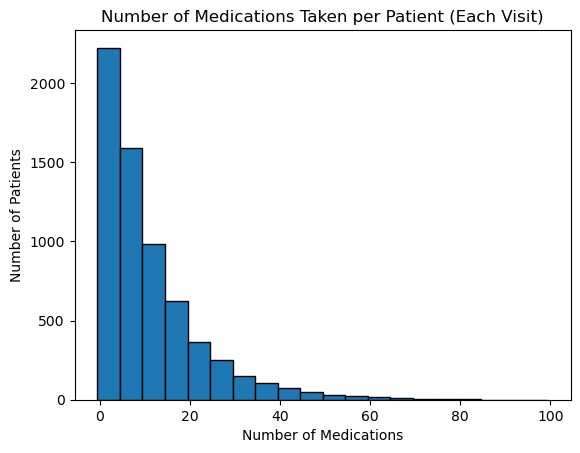

In [16]:
# Select only the medication indicator columns (all columns after the first 4)
med_cols = data.columns[5:]

# For each patient, aggregate across visits by taking the maximum indicator value for each medication.
# This ensures that if a patient ever took a medication (indicator 1) then it's counted.
med_taken = data.groupby('person_id')[med_cols].max()

# Count the number of medications taken per patient by summing the indicator values row-wise.
num_meds = med_taken.sum(axis=1)

# Count how many patients take a given number of medications.
med_counts = num_meds.value_counts().sort_index()
plt.hist(num_meds, bins=np.arange(num_meds.min()-0.5, num_meds.max()+1.5, 5), edgecolor='black')
# Plot a bar plot: x-axis is the number of medications, y-axis is the number of patients.
plt.xlabel('Number of Medications')
plt.ylabel('Number of Patients')
plt.title('Number of Medications Taken per Patient (Each Visit)')
plt.show()

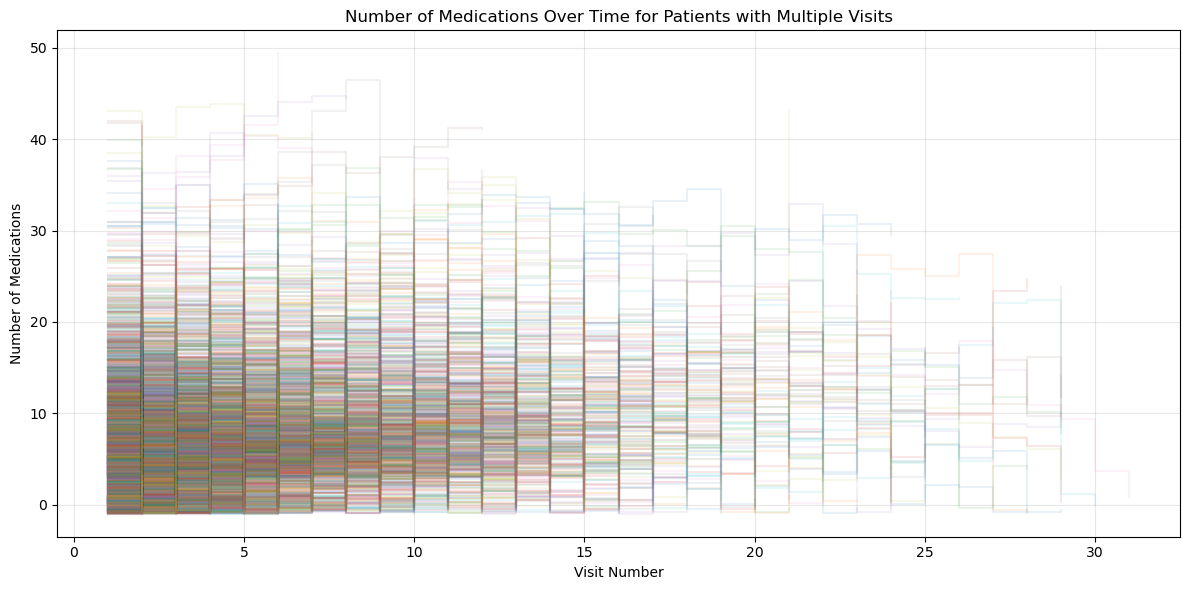

In [30]:
# Get patients with multiple visits
multiple_visits = visits[visits > 1].index

# Create a figure with larger size
plt.figure(figsize=(12, 6))

plt.xlabel('Visit Number')
plt.ylabel('Number of Medications')
plt.title('Number of Medications Over Time for Patients with Multiple Visits')
plt.grid(True, alpha=0.3)

# Limit to first 20 patients for better visibility
jitter_amount=1
sample_patients = multiple_visits[:20]

for patient in multiple_visits:
    # Get patient's data
    patient_data = data[data['person_id'] == patient]
    
    # Count medications for each visit
    med_counts = patient_data[med_cols].sum(axis=1)
    
    # Add jitter to y-coordinates
    jittered_y = med_counts + np.random.uniform(-jitter_amount, jitter_amount, len(med_counts))
    
    # Plot the line for this patient as a step function with jittered y-coordinates
    plt.step(patient_data['viscount'], jittered_y, '-', alpha=0.1, label=f'Patient {patient}', where='post')

plt.tight_layout()
plt.show()


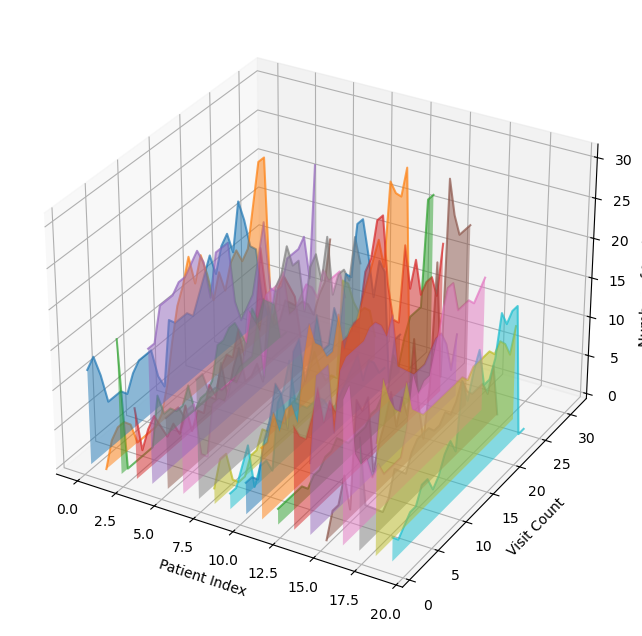

In [45]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Reorder patients with multiple visits by their number of visits (descending order)
sorted_patients = visits[visits > 1].sort_values(ascending=False).index[:20]

# Create a 3D figure
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Use the enumeration to assign equispaced x-coordinates
for idx, patient in enumerate(sorted_patients):
    # Get patient's data
    patient_data = data[data['person_id'] == patient]
    
    # Count medications for each visit
    med_counts = patient_data[med_cols].sum(axis=1)
    
    # Set x as the equispaced index
    x = [idx] * len(patient_data)
    y = patient_data['viscount']
    z = med_counts
    
    # Create baseline at zero
    zeros = np.zeros_like(z)
    
    # Plot the line and get its color
    line, = ax.plot(x, y, z, '-', alpha=0.7)
    line_color = line.get_color()
    
    # Build a closed polygon: start at baseline, follow the top then return along the baseline
    verts = [list(zip(x, y, zeros)) + list(zip(x[::-1], y[::-1], z[::-1]))]
    ax.add_collection3d(Poly3DCollection(verts, facecolors=line_color, alpha=0.5))

# Set titles on the axes
ax.set_xlabel('Patient Index')
ax.set_ylabel('Visit Count')
ax.set_zlabel('Number of Medications')

plt.show()


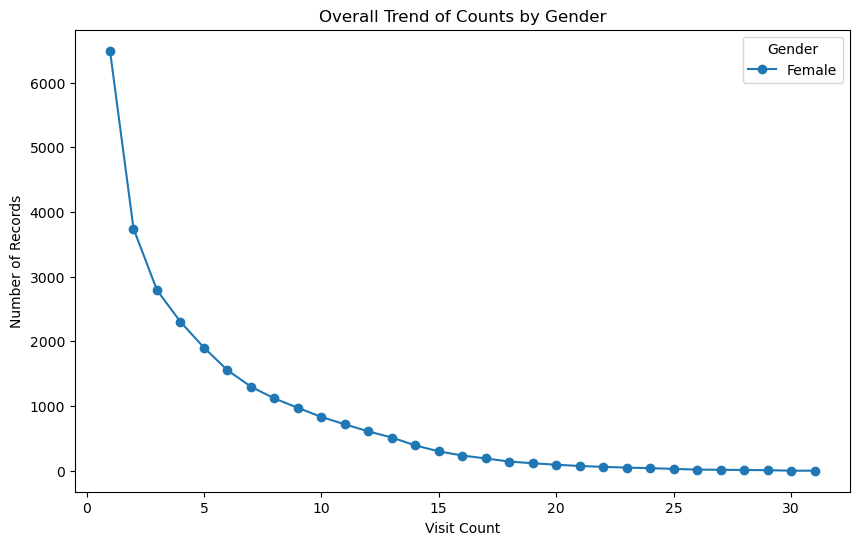

In [ ]:
# Group the data by 'viscount' and 'gender', then get the counts
trend = data.groupby(['viscount', 'gender']).size().reset_index(name='count')

# Pivot the table so that each gender becomes a column
trend_pivot = trend.pivot(index='viscount', columns='gender', values='count').fillna(0)

# Plot the trend using a line plot
trend_pivot.plot(marker='o', figsize=(10,6))
plt.xlabel('Visit Count')
plt.ylabel('Number of Records')
plt.title('Overall Trend of Counts by Gender')
plt.legend(title='Gender')


In [47]:
# Get the table of counts for the 'gender' variable
gender_counts = data['gender'].value_counts()
print(gender_counts)

gender
Female    26638
Name: count, dtype: int64


In [48]:
data['gender']

0        Female
1        Female
2        Female
3        Female
4        Female
          ...  
26633    Female
26634    Female
26635    Female
26636    Female
26637    Female
Name: gender, Length: 26638, dtype: object